# SPNC thermals
Code for experimenting with the effects of thermal variation on ML performance

Set up imports:

In [2]:
"""
Import handeling and Dependancy info

Local Dependancies
------------------
machine_learning_library  : v0.1.2
    This repository will need to be on your path in order to work.
    This is achieved with repo_tools module and a path find function
    Add to the searchpath and repos tuples if required


"""

import numpy as np
import matplotlib.pyplot as plt

# Sort out relative paths
import sys
from pathlib import Path
repodir = Path('..').resolve()
try:
    sys.path.index(str(repodir))
except ValueError:
    sys.path.append(str(repodir))

#tuple of Path variables
searchpaths = (Path.home() / 'repos', )
#tuple of repos
repos = ('machine_learning_library',)

# local imports
from SPNC import spnc
#ML specific
from SPNC.deterministic_mask import fixed_seed_mask, max_sequences_mask
import SPNC.repo_tools
SPNC.repo_tools.repos_path_finder(searchpaths, repos) #find ml library
from single_node_res import single_node_reservoir
import ridge_regression as RR
from linear_layer import *
from mask import binary_mask
from utility import *
from NARMA10 import NARMA10
from sklearn.metrics import classification_report

Establish shared parameters

In [22]:
'''
NARMA10 response
'''

plt.rcParams['text.usetex'] = True

figurewidth = 3.37*2.5
figureaspect = 2/3
figureheight = figurewidth*figureaspect

# NARMA parameters
Ntrain = 100
Ntest = 50

# Net Parameters
Nvirt = 5
m0 = 0.003
bias = True

# Misc parameters
seed_NARMA = 1234
fixed_mask = False
spacer = 5

theta = 0.4
gamma = 0.132
delay_feedback = 0
params = {'theta': theta, 'gamma' : gamma,'delay_feedback' : delay_feedback,'Nvirt' : Nvirt}


def get_res(h=0.4,theta_H=90,k_s_0=0,phi=45,beta_prime=20):
    res = spnc.spnc_anisotropy(h,theta_H,k_s_0,phi,beta_prime)
    transform = res.gen_signal_fast_delayed_feedback

    return res, transform

base_beta_prime = 20
spnres, transform = get_res(beta_prime=base_beta_prime)
spnreshigher, transformhigher = get_res(beta_prime=base_beta_prime)

Data and net setup

seed NARMA: 1234
Samples for training:  100
Samples for test:  50
Nin = 1 , Nout =  100 , Nvirt =  400


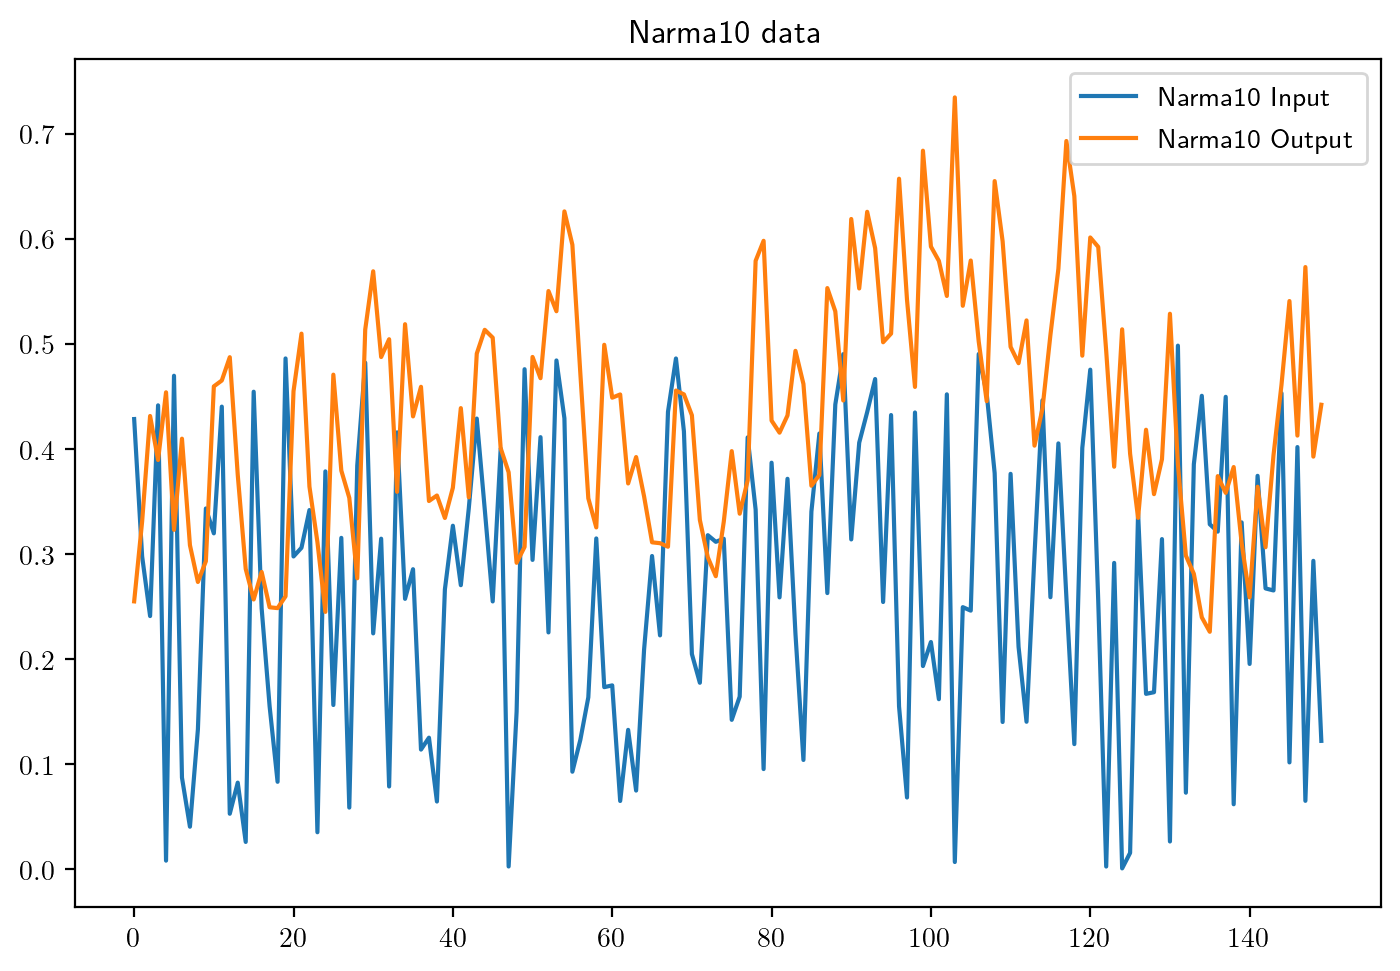

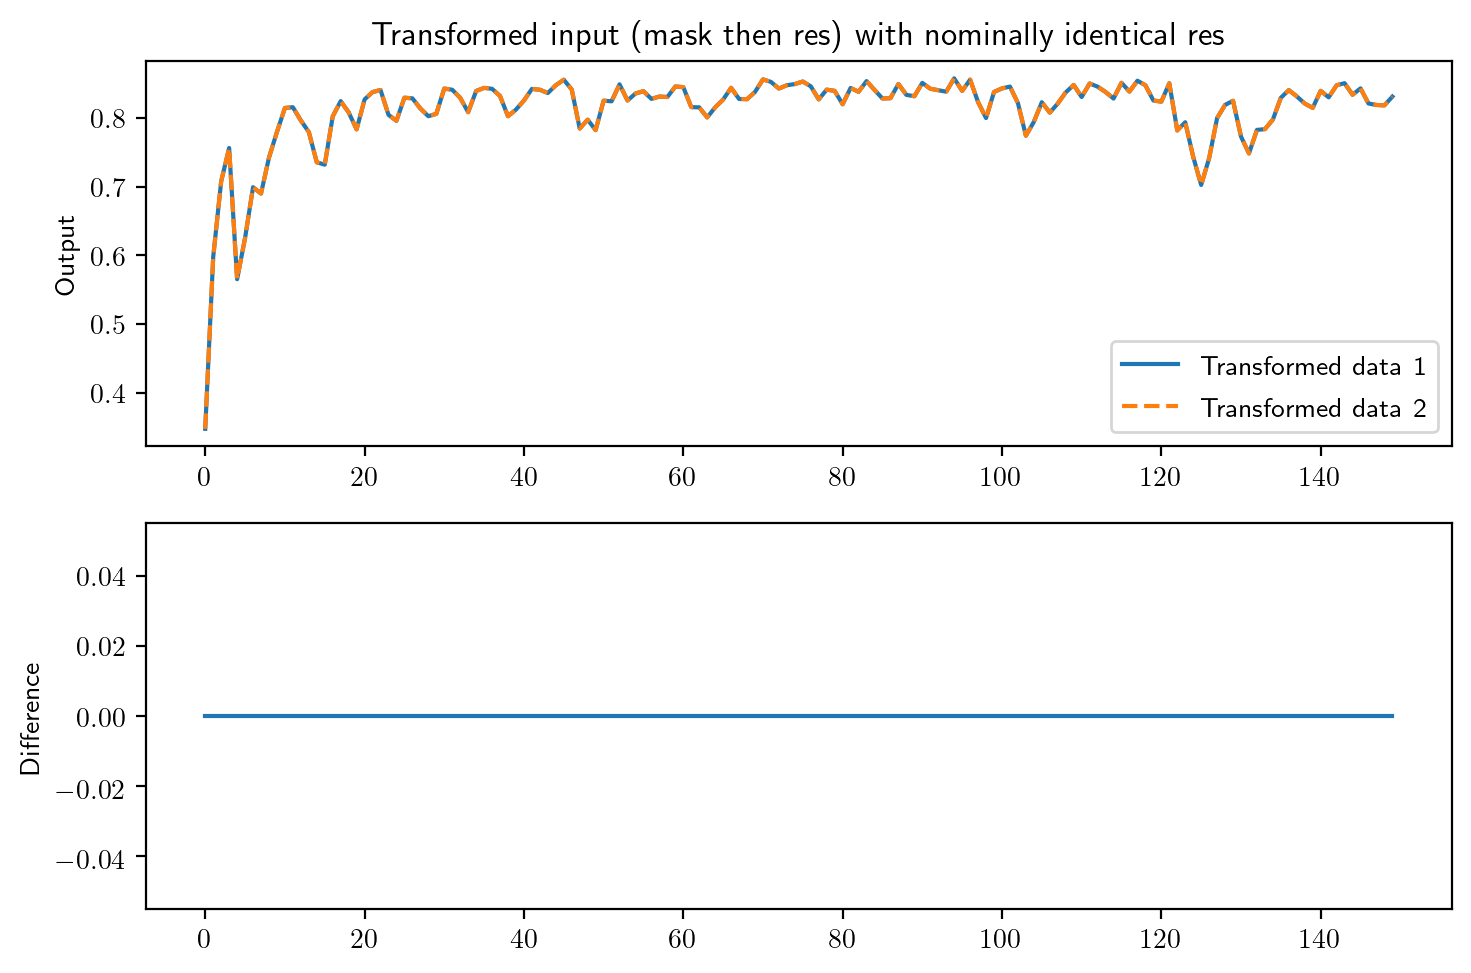

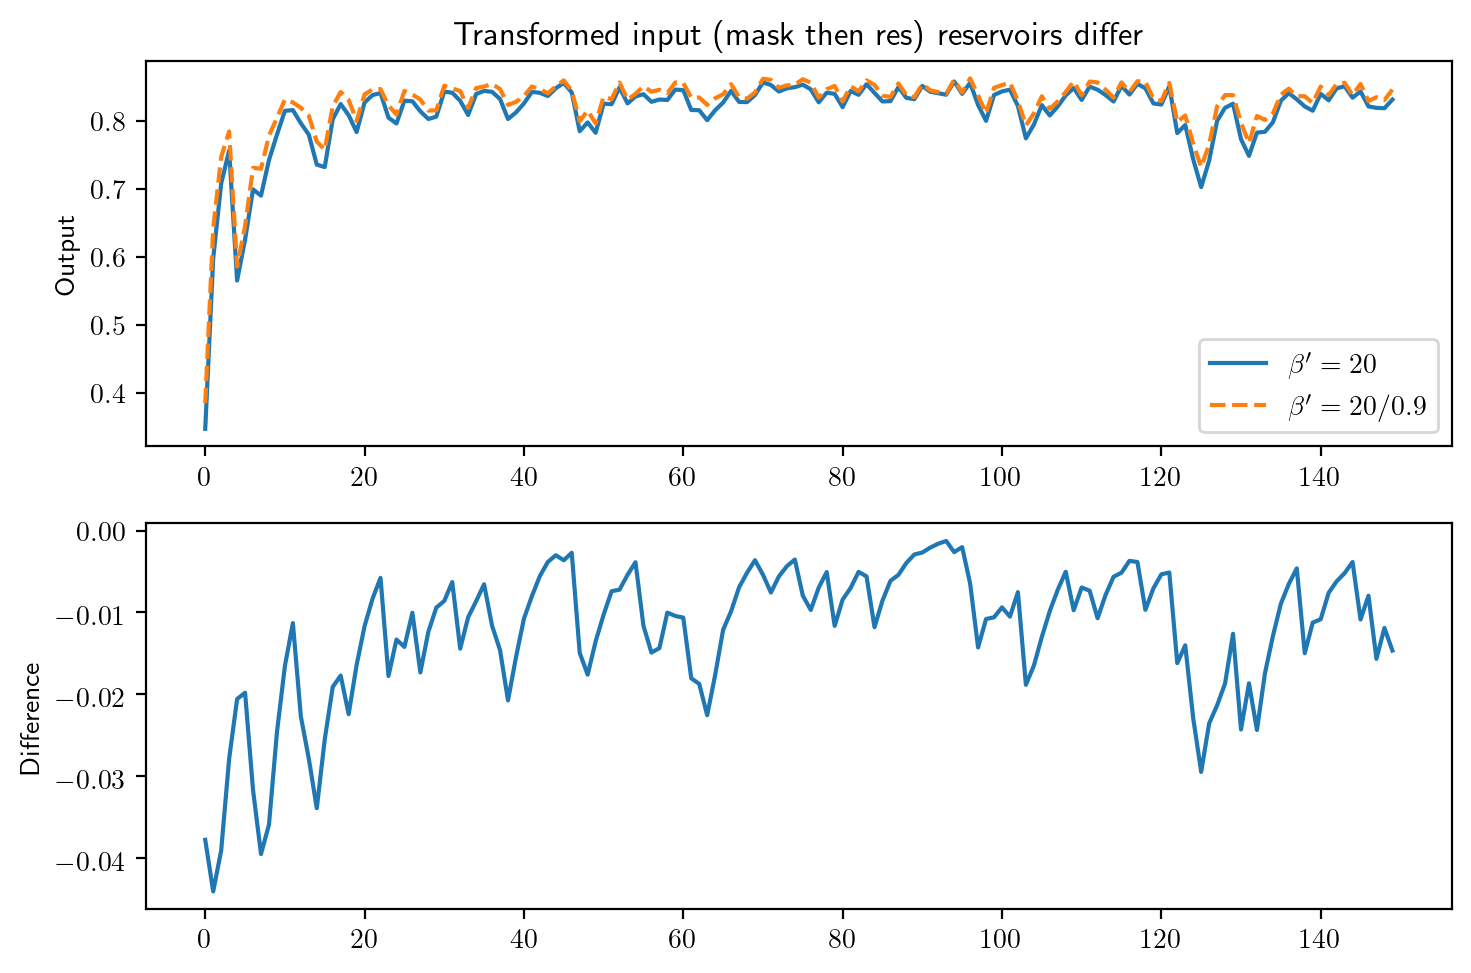

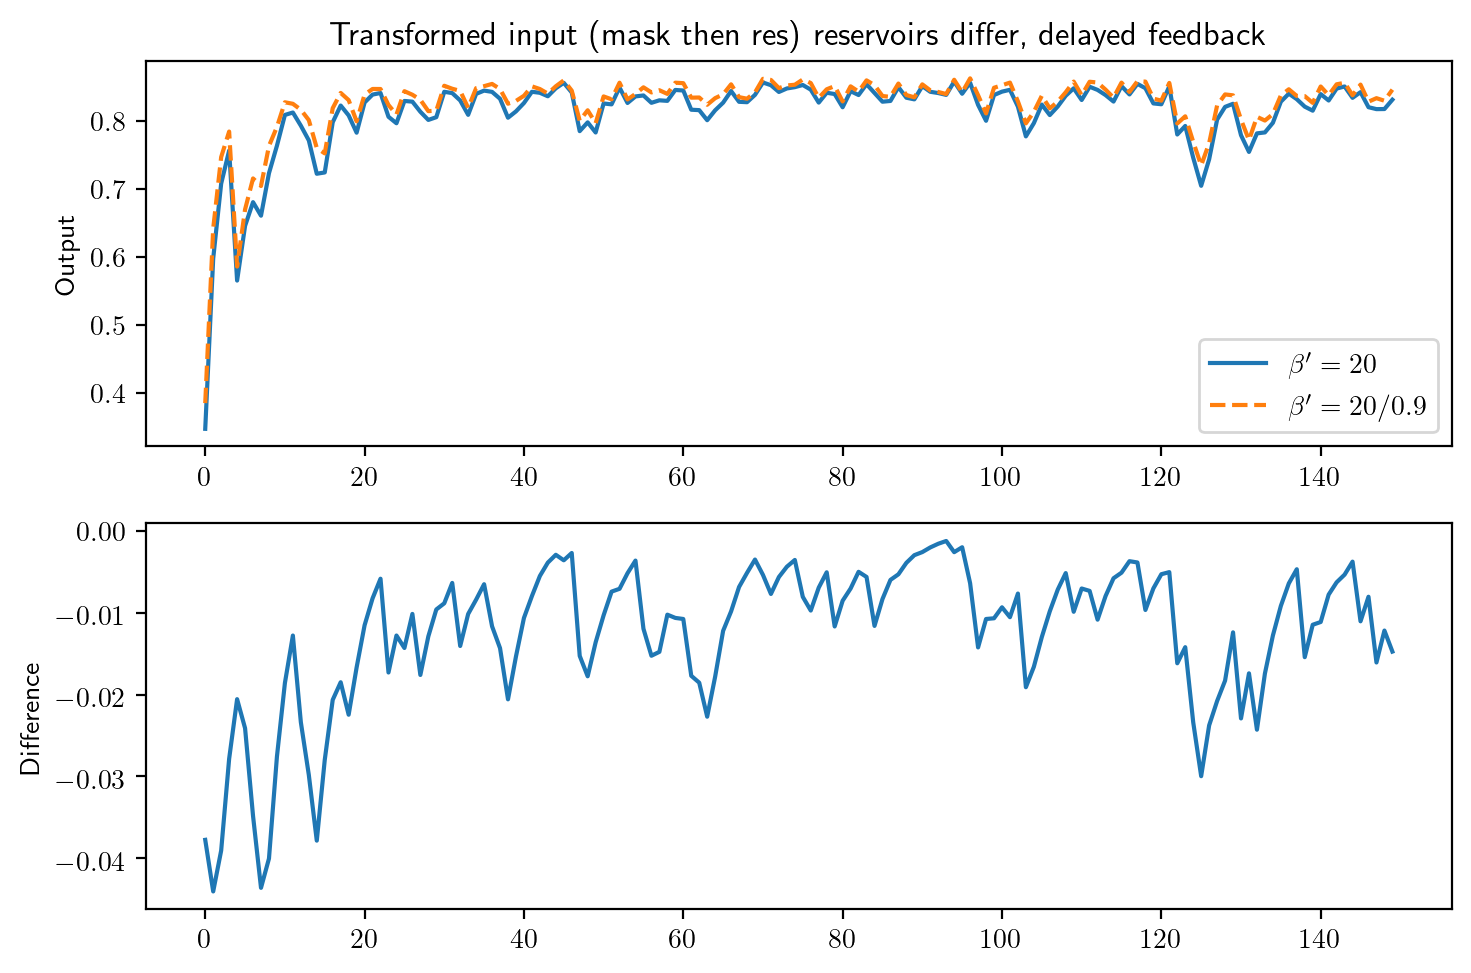

In [59]:
# Testing output properties

# Misc parameters
params = {'theta': 0.4, 'gamma' : 0.132,'delay_feedback' : 0,'Nvirt' : 5}
params2 = {'theta': 0.4, 'gamma' : 0.132,'delay_feedback' : 0,'Nvirt' : 5}
params3 = {'theta': 0.4, 'gamma' : 0.132,'delay_feedback' : 1,'Nvirt' : 5}
Ntrain = 100
Ntest = 50

print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)

fig, ax = plt.subplots(1,figsize=[figurewidth,figureheight],dpi=200)
ax.plot(u)
ax.plot(d)
ax.legend(['Narma10 Input','Narma10 Output'])
ax.set_title('Narma10 data')

transform_1 = get_res(beta_prime=base_beta_prime)[1]
transform_2 = get_res(beta_prime=base_beta_prime)[1]
transform_3 = get_res(beta_prime=base_beta_prime/0.9)[1]

transform_4 = get_res(beta_prime=base_beta_prime)[1]
transform_5 = get_res(beta_prime=base_beta_prime/0.9)[1]

transformed_1 = transform_1(u,params)
transformed_2 = transform_2(u,params)
transformed_3 = transform_3(u,params)

transformed_4 = transform_4(u,params3)
transformed_5 = transform_5(u,params3)


fig,ax = plt.subplots(2,figsize=[figurewidth,figureheight],dpi=200)
ax[0].plot(transformed_1)
ax[0].plot(transformed_2,linestyle='dashed')
ax[0].set_title('Transformed input (mask then res) with nominally identical res')
ax[0].legend(['Transformed data 1','Transformed data 2'])
ax[0].set_ylabel('Output')
ax[1].plot(transformed_1-transformed_2)
ax[1].set_ylabel('Difference')

fig,ax = plt.subplots(2,figsize=[figurewidth,figureheight],dpi=200)
ax[0].plot(transformed_1)
ax[0].plot(transformed_3,linestyle='dashed')
ax[0].set_title('Transformed input (mask then res) reservoirs differ')
ax[0].legend([r"$\beta' = 20$",r"$\beta' = 20/0.9$"])
ax[0].set_ylabel('Output')
ax[1].plot(transformed_1-transformed_3)
ax[1].set_ylabel('Difference')

fig,ax = plt.subplots(2,figsize=[figurewidth,figureheight],dpi=200)
ax[0].plot(transformed_4)
ax[0].plot(transformed_5,linestyle='dashed')
ax[0].set_title('Transformed input (mask then res) reservoirs differ, delayed feedback')
ax[0].legend([r"$\beta' = 20$",r"$\beta' = 20/0.9$"])
ax[0].set_ylabel('Output')
ax[1].plot(transformed_4-transformed_5)
ax[1].set_ylabel('Difference')

x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

Training and testing:

seed NARMA: 1234
Samples for training:  500
Samples for test:  250
Nin = 1 , Nout =  500 , Nvirt =  400
Using Nthreads =  1
Seed Training: 1234
l= 4.5399929762484854e-05 0.008225914517225165
l= 5.017468205617528e-05 0.00822561135648527
l= 5.5451599432176945e-05 0.008225304191536189
l= 6.128349505322202e-05 0.008224992677001752
l= 6.772873649085378e-05 0.008224676850237301
l= 7.485182988770046e-05 0.008224357170921081
l= 8.272406555663209e-05 0.008224034561019118
l= 9.142423147817311e-05 0.008223710442879
l= 0.00010103940183709307 0.008223386773551134
l= 0.00011166580849011438 0.008223066072125
l= 0.0001234098040866791 0.008222751437070618
l= 0.0001363889264820109 0.00822244655018681
l= 0.00015073307509547596 0.008222155663561631
l= 0.00016658581098763264 0.008221883566717953
l= 0.00018410579366757822 0.008221635531468607
l= 0.00020346836901064308 0.008221417233337514
l= 0.000224867324178847 0.008221234650045125
l= 0.0002485168271079505 0.008221093939501666
l= 0.0002746535699721406 0.00

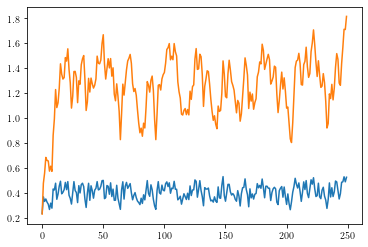

Error and NRMSE for normal testing 0.00628950041806659 0.8362276140103926
Error and NRMSE for higher temp testing 0.8148498707702768 9.518208854237395


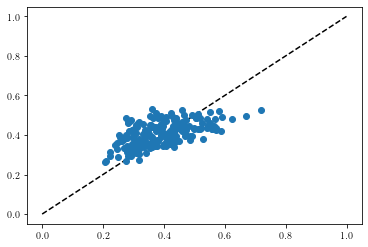

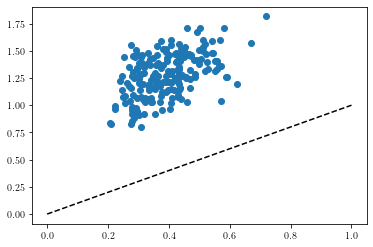

In [49]:
# Training at one temp, testing at another

# Misc parameters
params = {'theta': 0.4, 'gamma' : 0.132,'delay_feedback' : 0,'Nvirt' : 50}
Ntrain = 500
Ntest = 250
spacer = 50

print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)


transform = get_res(beta_prime=base_beta_prime)[1]
transformhigher = get_res(beta_prime=base_beta_prime/0.9)[1]


x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

# Training
S_train, J_train = snr.transform(x_train,params)
np.size(S_train)
seed_training = 1234
RR.Kfold_train(net,S_train,y_train,10, quiet = False)

# Testing
S_test, J_test = snr.transform(x_test,params)
#test with the other transform...
snr.res = transformhigher
S_test_higher, J_test_higher = snr.transform(x_test,params)


print("Spacer NRMSE:"+str(spacer))
pred = net.forward(S_test)
pred_higher = net.forward(S_test_higher)
plt.plot(pred)
plt.plot(pred_higher)
plt.show()
np.size(pred)
error = MSE(pred[spacer:], y_test[spacer:])
predNRMSE = NRMSE(pred[spacer:], y_test[spacer:])
print('Error and NRMSE for normal testing', error, predNRMSE)

error_higher = MSE(pred_higher[spacer:], y_test[spacer:])
predNRMSE_higher = NRMSE(pred_higher[spacer:], y_test[spacer:])
print('Error and NRMSE for higher temp testing', error_higher, predNRMSE_higher)

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred[spacer:],'o')
plt.show()

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred_higher[spacer:],'o')
plt.show()

seed NARMA: 1234
Samples for training:  50
Samples for test:  50
Nin = 1 , Nout =  50 , Nvirt =  400
Using Nthreads =  1
Seed Training: 1234
l= 4.5399929762484854e-05 0.008620626421619742
l= 5.017468205617528e-05 0.008627864200820146
l= 5.5451599432176945e-05 0.00863441524036482
l= 6.128349505322202e-05 0.008640340167976853
l= 6.772873649085378e-05 0.008645694226782154
l= 7.485182988770046e-05 0.008650527673649915
l= 8.272406555663209e-05 0.008654886154689925
l= 9.142423147817311e-05 0.008658811057109783
l= 0.00010103940183709307 0.008662339837154951
l= 0.00011166580849011438 0.008665506324210157
l= 0.0001234098040866791 0.00866834100151503
l= 0.0001363889264820109 0.008670871264121926
l= 0.00015073307509547596 0.008673121654924964
l= 0.00016658581098763264 0.008675114079666004
l= 0.00018410579366757822 0.008676868001909343
l= 0.00020346836901064308 0.008678400619008531
l= 0.000224867324178847 0.00867972702008962
l= 0.0002485168271079505 0.00868086032709543
l= 0.0002746535699721406 0.0

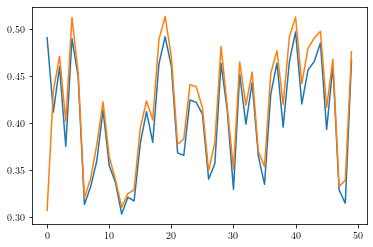

Error and NRMSE for normal testing 0.01095147228995827 0.988215836105556
Error and NRMSE for higher temp testing 0.010056163455176704 0.9469601791654989


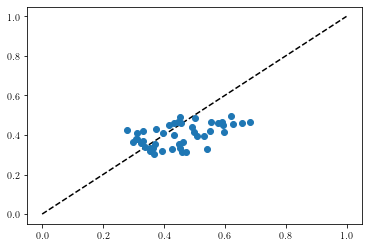

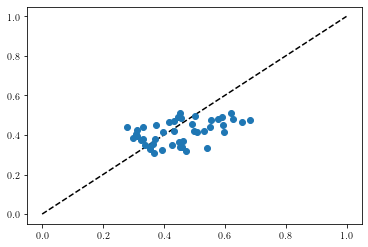

In [52]:
# Training at one temp, testing at another

# Misc parameters
params = {'theta': 0.4, 'gamma' : 0,'delay_feedback' : 0,'Nvirt' : 5}
Ntrain = 50
Ntest = 50
spacer = 5

print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)


transform = get_res(beta_prime=base_beta_prime)[1]
transformhigher = get_res(beta_prime=base_beta_prime/1.01)[1]


x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

# Training
S_train, J_train = snr.transform(x_train,params)
np.size(S_train)
seed_training = 1234
RR.Kfold_train(net,S_train,y_train,10, quiet = False)

# Testing
S_test, J_test = snr.transform(x_test,params)
#test with the other transform...
snr.res = transformhigher
S_test_higher, J_test_higher = snr.transform(x_test,params)


print("Spacer NRMSE:"+str(spacer))
pred = net.forward(S_test)
pred_higher = net.forward(S_test_higher)
plt.plot(pred)
plt.plot(pred_higher)
plt.show()
np.size(pred)
error = MSE(pred[spacer:], y_test[spacer:])
predNRMSE = NRMSE(pred[spacer:], y_test[spacer:])
print('Error and NRMSE for normal testing', error, predNRMSE)

error_higher = MSE(pred_higher[spacer:], y_test[spacer:])
predNRMSE_higher = NRMSE(pred_higher[spacer:], y_test[spacer:])
print('Error and NRMSE for higher temp testing', error_higher, predNRMSE_higher)

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred[spacer:],'o')
plt.show()

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred_higher[spacer:],'o')
plt.show()

seed NARMA: 1234
Samples for training:  50
Samples for test:  50
Nin = 1 , Nout =  50 , Nvirt =  400
Using Nthreads =  1
Seed Training: 1234
l= 4.5399929762484854e-05 0.006659694518410067
l= 5.017468205617528e-05 0.00677701353854881
l= 5.5451599432176945e-05 0.006892409057620138
l= 6.128349505322202e-05 0.007005235274930627
l= 6.772873649085378e-05 0.007114923449194241
l= 7.485182988770046e-05 0.007220987449017319
l= 8.272406555663209e-05 0.0073230260634626135
l= 9.142423147817311e-05 0.007420722425771545
l= 0.00010103940183709307 0.007513840999678227
l= 0.00011166580849011438 0.007602222626933218
l= 0.0001234098040866791 0.007685778141784854
l= 0.0001363889264820109 0.007764481033312981
l= 0.00015073307509547596 0.007838359587498641
l= 0.00016658581098763264 0.0079074888779488
l= 0.00018410579366757822 0.007971982904453672
l= 0.00020346836901064308 0.00803198710894202
l= 0.000224867324178847 0.008087671432846406
l= 0.0002485168271079505 0.008139224022019982
l= 0.0002746535699721406 0.

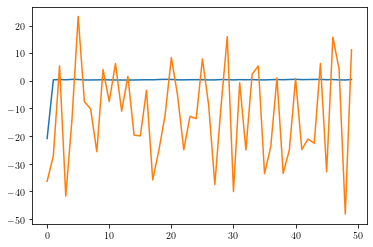

Error and NRMSE for normal testing 0.010158520565467875 0.9517673160265665
Error and NRMSE for higher temp testing 422.1570119018332 194.02270649606962


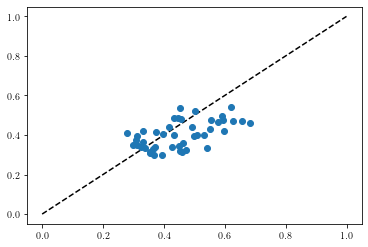

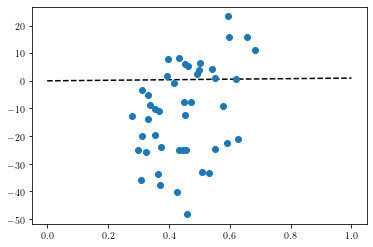

In [60]:
# Training at one temp, testing at another

# Misc parameters
params = {'theta': 0.4, 'gamma' : 0.132,'delay_feedback' : 1,'Nvirt' : 5}
Ntrain = 50
Ntest = 50
spacer = 5

print("seed NARMA: "+str(seed_NARMA))
u, d = NARMA10(Ntrain + Ntest,seed=seed_NARMA)


transform = get_res(beta_prime=base_beta_prime)[1]
transformhigher = get_res(beta_prime=base_beta_prime/1.01)[1]


x_train = u[:Ntrain]
y_train = d[:Ntrain]
x_test = u[Ntrain:]
y_test = d[Ntrain:]

print("Samples for training: ", len(x_train))
print("Samples for test: ", len(x_test))

# Net setup
Nin = x_train[0].shape[-1]
Nout = len(np.unique(y_train))

print( 'Nin =', Nin, ', Nout = ', Nout, ', Nvirt = ', Nvirt)

snr = single_node_reservoir(Nin, Nout, Nvirt, m0, res = transform)
net = linear(Nin, Nout, bias = bias)

# Training
S_train, J_train = snr.transform(x_train,params)
np.size(S_train)
seed_training = 1234
RR.Kfold_train(net,S_train,y_train,10, quiet = False)

# Testing
S_test, J_test = snr.transform(x_test,params)
#test with the other transform...
snr.res = transformhigher
S_test_higher, J_test_higher = snr.transform(x_test,params)


print("Spacer NRMSE:"+str(spacer))
pred = net.forward(S_test)
pred_higher = net.forward(S_test_higher)
plt.plot(pred)
plt.plot(pred_higher)
plt.show()
np.size(pred)
error = MSE(pred[spacer:], y_test[spacer:])
predNRMSE = NRMSE(pred[spacer:], y_test[spacer:])
print('Error and NRMSE for normal testing', error, predNRMSE)

error_higher = MSE(pred_higher[spacer:], y_test[spacer:])
predNRMSE_higher = NRMSE(pred_higher[spacer:], y_test[spacer:])
print('Error and NRMSE for higher temp testing', error_higher, predNRMSE_higher)

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred[spacer:],'o')
plt.show()

plt.plot( np.linspace(0.0,1.0), np.linspace(0.0,1.0),'k--')
plt.plot(y_test[spacer:],pred_higher[spacer:],'o')
plt.show()